In [6]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [12]:
sentimiento= pd.read_excel('./data/final.xlsx')

In [13]:
sentimiento.head(10)

,Texto,Unnamed: 1,Sentimiento
0,Aprendi regresiones,Positivo,1
1,Mucha tarea,Negativo,0
2,Aprendi modelos de texto,Positivo,1
3,Tareas muy largas,Negativo,0
4,Aprendi a utilizar imágenes,Positivo,1
5,El profe se demora en entregar las notas,Negativo,0
6,Me gusto competir por el mejor modelo,Positivo,1
7,Los examenes son largos,Negativo,0
8,Aprendi gradientes,Positivo,1
9,Aprendi NLP,Positivo,1


In [24]:
masFrecuentes = df['Texto'].str.split(expand=True).stack().value_counts()[:10]

# Punto 1

Exploración, crear un gráfico de barras con las 10 palabras más frecuentes. Calcular la correlación con el sentimiento. Si el sentimiento positivo es 1 y el negativo es 0 (10 puntos) 

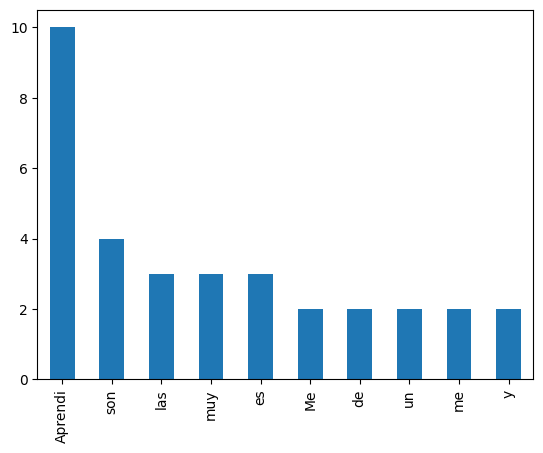

In [25]:
masFrecuentes.plot(kind='bar')
plt.show()

In [43]:
df['valor_asignado'] = df['Texto'].apply(lambda x: sum(x in masFrecuentes for x in x.split()))

In [44]:
#valores_asignados = {palabra: valor + 1 for valor, palabra in enumerate(masFrecuentes)}
#df['valor_asignado'] = df['Texto'].apply(lambda x: sum(valores_asignados[palabra] for palabra in x.split() if palabra in masFrecuentes))

In [35]:
correlacion = df[['valor_asignado', 'Sentimiento']].corr().iloc[0, 1]

In [36]:
print(f'10 palabras más frecuentes: {masFrecuentes}')

10 palabras más frecuentes: Aprendi    10
son         4
las         3
muy         3
es          3
Me          2
de          2
un          2
me          2
y           2
Name: count, dtype: int64


In [45]:
print(f'Valor asignado a las palabras más frecuentes:\n{df[["Texto"] + ["valorAsignado"]].head()}')

Valor asignado a las palabras más frecuentes:
                         Texto  valorAsignado
0          Aprendi regresiones              1
1                  Mucha tarea              0
2     Aprendi modelos de texto              2
3            Tareas muy largas              1
4  Aprendi a utilizar imágenes              1


In [46]:
print(f'Correlación con el sentimiento: {correlacion}')

Correlación con el sentimiento: 0.2033810364680433


# Punto 2

 Crear la matriz tf-idf. Ordene las columnas por las palabras mas comunes

In [66]:
def calcular_tf(sentimiento):
    tf = {}
    for palabra in sentimiento.split():
        if palabra in tf:
            tf[palabra] += 1
        else:
            tf[palabra] = 1
    for palabra in tf:
        tf[palabra] = tf[palabra] / len(sentimiento.split())
    return tf


In [70]:
def calcular_idf(sentimiento):
    idf = {}
    n_sentimientos = len(sentimiento)
    for sentimientos in sentimiento:
        for palabra in sentimientos.split():
            if palabra in idf:
                continue
            apariciones = sum([1 for d in sentimiento if palabra in d.split()])
            idf[palabra] = np.log(n_sentimientos / apariciones)
        return idf

In [71]:
def calcular_tf_idf(sentimiento):
    tf_idf = []
    idf = calcular_idf(sentimiento)
    for sentimientos in sentimiento:
        tf = calcular_tf(sentimientos)
        tf_idf.append([tf[palabra] * idf[palabra] if palabra in tf else 0 for palabra in idf])
    return np.array(tf_idf)

In [72]:
tf_idf = calcular_tf_idf(df['Texto'])
print(tf_idf)

[[0.34657359 1.49786614]
 [0.         0.        ]
 [0.1732868  0.        ]
 [0.         0.        ]
 [0.1732868  0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.34657359 0.        ]
 [0.34657359 0.        ]
 [0.23104906 0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.34657359 0.        ]
 [0.1732868  0.        ]
 [0.13862944 0.        ]
 [0.         0.        ]
 [0.09902103 0.        ]
 [0.         0.        ]
 [0.         0.        ]]


# Punto 3

In [121]:
tf = df['Texto'].apply(lambda x: pd.Series(x).value_counts())

idf = np.log(len(df) / tf.count())
tf_idf = tf * idf
tf_idf = tf_idf.reindex(tf.sum().sort_values(ascending=False).index, axis=1)
tf_idf['b0'] = 1
tf_idf = tf_idf.fillna(0)

In [127]:
b = np.zeros(tf_idf.shape[1])

learning_rate = 0.5
batch_size = 3
epochs = 15

In [128]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [136]:
for i in range(epochs):
    for j in range(0, len(df), batch_size):
        X = tf.constant(tf_idf.iloc[j:j+batch_size].values, dtype=tf.float64)
        
        with tf.GradientTape() as tape:
            g = tf.matmul(X, b)
            y_pred = sigmoid(g)
            error = -tf.reduce_sum(y * tf.math.log(y_pred) + (1 - y) * tf.math.log(1 - y_pred))
        
        gradient = tape.gradient(error, b)
        b.assign_sub(learning_rate * gradient)

    print(f'Iteración {i+1}: {b.numpy()[:4, 0]}')

SyntaxError: invalid non-printable character U+00A0 (2798102017.py, line 13)

# Punto 4

# Punto 5

Cree el modelo en python utilizando las librerías, que palabras son las mas importantes. Adicionar tabla de coeficientes y comentar resultados

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df['Texto'], df['Sentimiento'], test_size=0.7, random_state=53)

In [117]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [118]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

accuracy = accuracy_score(y_test, model.predict(X_test_vec))
print(f'Precisión del modelo: {accuracy}')

Precisión del modelo: 0.7142857142857143


In [85]:
coeficients = model.coef_[0]
coeficientes_df = pd.DataFrame({'Palabra': vectorizer.get_feature_names_out(), 'Coeficiente': coeficients})
print(coeficientes_df)

        Palabra  Coeficiente
0       aprendi     0.363141
1       cluster     0.164982
2        confio    -0.158308
3            de     0.039851
4        demora    -0.204818
5     distraigo    -0.158308
6            el    -0.204818
7            en    -0.363126
8      entregar    -0.204818
9            es     0.164982
10  grabaciones    -0.158308
11           la    -0.158308
12          las    -0.363126
13           me    -0.316615
14      modelos     0.198158
15        notas    -0.204818
16        parte    -0.158308
17        profe    -0.204818
18          que     0.164982
19           se    -0.204818
20      teorica    -0.158308
21        texto     0.198158
22           un     0.164982


En la tabla de coeficientes se presentan las palabras más importantes y el calculo de su coeficiente

Aquellas palabras con coeficientes en valor absoluto, más grandes tienen una influencia más fuerte en la predicción del modelo. Estas palabras son de suma importancia para determinar la clase predicha.

El modelo presenta un accuracy del 71%, lo cuál en términos general no es muy bueno pero tampoco es malo